## Prueba 1 Modelo de Red Neuronal Sencillo

Vamos a comenzar por un modelo de red neuronal sencillo. Vamos primero a obviar el hecho de que están desbalanceadas las clases. Vamos a reportar f1 score para intentar solucionar el problema del desbalanceado.

En todos los casos que probemos vamos a utilizar oversampling y undersampling para comparar

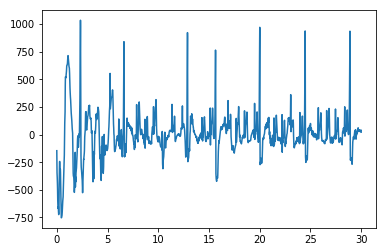

In [12]:
#load data
#load data
%matplotlib inline
import matplotlib.pyplot as plt
#load data
import numpy as np

X_train = np.load('X_train.npy')
y_train = np.load('y_train.npy')

X_test = np.load('X_test.npy')
y_test = np.load('y_test.npy')

#Decimamos

X_train = np.load('X_train.npy')
y_train = np.load('y_train.npy')

X_test = np.load('X_test.npy')
y_test = np.load('y_test.npy')

fs = 300. #hz
t = np.arange(len(X_train[0]))/fs
plt.plot(t,X_train[0,:])

#Es probable que tengamos un problema mal condicionado: vamos a realizar un submuestreo de la señal a 50 muestras por segundo
from scipy import signal

decimate = False

if decimate:
    freq = fs/10#Hz
    print(freq)
    secs = len(X_train[200])/fs
    samps = int(secs*freq)
    c = 0
    X_new = np.zeros((X_train.shape[0],samps))
    X_new_test = np.zeros((X_test.shape[0],samps))
    for x,x_test in zip(X_train,X_test):
        X_new[c,:] = signal.decimate(x,10,ftype = 'fir')
        X_new_test[c,:] = signal.decimate(x_test,10,ftype = 'fir')
    
        c += 1
    
    t = np.arange(len(X_new[200]))/freq
    plt.plot(t,X_new[200,:])
    print(len(X_new[0]))

    X_train = X_new.copy()
    X_test = X_new_test.copy()

## Preprocesamos los datos

In [13]:
from sklearn.preprocessing import StandardScaler

#normalizamos train
my_scaler = StandardScaler()

X_train_n = my_scaler.fit_transform(X_train)

/home/miguelangel/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


## Under sampling y over sampling

Siempre sobre datos de entrada normalizados

In [14]:
#Vamos a probar balanceando con under sampling y over sampling
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0, replacement=True)
X_resampled, y_resampled = rus.fit_sample(X_train_n, y_train)

from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_oversampled, y_oversampled = ros.fit_sample(X_train_n, y_train)

print('"""""""""""""""""""""""""""""""""""""""""""""""""')
print('"""""""""""""""""""""""""""""""""""""""""""""""""')
print("y_resampled")
print(sorted(Counter(y_resampled).items()))

print("y_oversampled")
print(sorted(Counter(y_oversampled).items()))


print("y_train")
print(sorted(Counter(y_train).items()))

"""""""""""""""""""""""""""""""""""""""""""""""""
"""""""""""""""""""""""""""""""""""""""""""""""""
y_resampled
[(0, 100), (1, 100), (2, 100), (3, 100)]
y_oversampled
[(0, 2942), (1, 2942), (2, 2942), (3, 2942)]
y_train
[(0, 2942), (1, 399), (2, 1340), (3, 100)]


## Diseño red neuronal

In [15]:
#función para crear un modelo de un número determinado de capas

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras import initializers
from keras.layers.normalization import BatchNormalization
import keras


#f1 score
from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def create_model(N,n_hidd = [2,2,2]):
    """
    Modelo de red neuronal. 
    
    N: number of input featurs
    n_hidd indica la arquitectura del modelo: n_cols = número de capas, value for eahc col, the number of hidden
    units
    """
    
    model = Sequential()
    
    #input layer
    model.add(Dense(n_hidd[0],input_dim = N,activation = 'relu'))
    model.add(BatchNormalization())
    
    #hidden layers
    for n_h in n_hidd[1:]:
        model.add(Dense(n_h,activation='relu',kernel_initializer=initializers.he_normal(seed=None)))
        model.add(BatchNormalization())
        model.add(Dropout(0.9))
        
    #output layer
    model.add(Dense(4,activation = 'softmax'))
   

    opt =keras.optimizers.Adam(lr = 4e-3)
    #compile model
    model.compile(loss='categorical_crossentropy',optimizer = opt,metrics = ['accuracy',f1])
    return model

## Datos normalizados sin balancear

In [16]:
#Split data into dev and trin
from sklearn.model_selection import StratifiedShuffleSplit
skf = StratifiedShuffleSplit(n_splits = 1,test_size = 0.20)

#WARNING que volvemos a llamar train
for train, dev in skf.split(X_train_n,y_train):
    X_train, X_dev = X_train_n[train], X_train_n[dev]
    y_train, y_dev = y_train[train], y_train[dev]
    
print(X_train.shape)
print(X_dev.shape)

(3824, 9000)
(957, 9000)


In [17]:
#Entrenamos el modelo 

N = X_train.shape[1]#number of features
print(N)
model = KerasClassifier(build_fn = create_model,N=N, epochs = 150, batch_size = 10, verbose = 1)

history = model.fit(X_train,y_train)

9000
Epoch 1/150
3824/3824 [==============================] - 2s 455us/step - loss: 1.2433 - acc: 0.6093 - f1: 0.2222
Epoch 2/150
3824/3824 [==============================] - 1s 359us/step - loss: 1.0322 - acc: 0.6114 - f1: 0.6115
Epoch 3/150
3824/3824 [==============================] - 1s 350us/step - loss: 0.9546 - acc: 0.6135 - f1: 0.6134
Epoch 4/150
3824/3824 [==============================] - 1s 353us/step - loss: 0.9460 - acc: 0.6153 - f1: 0.6151
Epoch 5/150
3824/3824 [==============================] - 1s 353us/step - loss: 0.9445 - acc: 0.6153 - f1: 0.6151
Epoch 6/150
3824/3824 [==============================] - 1s 359us/step - loss: 0.9449 - acc: 0.6153 - f1: 0.6145
Epoch 7/150
3824/3824 [==============================] - 1s 353us/step - loss: 0.9443 - acc: 0.6153 - f1: 0.6153
Epoch 8/150
3824/3824 [==============================] - 1s 356us/step - loss: 0.9444 - acc: 0.6153 - f1: 0.6153
Epoch 9/150
3824/3824 [==============================] - 1s 357us/step - loss: 0.9441 - acc

3824/3824 [==============================] - 1s 346us/step - loss: 0.9440 - acc: 0.6153 - f1: 0.6153
Epoch 73/150
3824/3824 [==============================] - 1s 346us/step - loss: 0.9444 - acc: 0.6153 - f1: 0.6153
Epoch 74/150
3824/3824 [==============================] - 1s 336us/step - loss: 0.9439 - acc: 0.6153 - f1: 0.6153
Epoch 75/150
3824/3824 [==============================] - 1s 355us/step - loss: 0.9440 - acc: 0.6151 - f1: 0.6151
Epoch 76/150
3824/3824 [==============================] - 1s 343us/step - loss: 0.9447 - acc: 0.6153 - f1: 0.6153
Epoch 77/150
3824/3824 [==============================] - 1s 335us/step - loss: 0.9436 - acc: 0.6153 - f1: 0.6153
Epoch 78/150
3824/3824 [==============================] - 1s 350us/step - loss: 0.9446 - acc: 0.6153 - f1: 0.6153
Epoch 79/150
3824/3824 [==============================] - 1s 357us/step - loss: 0.9441 - acc: 0.6153 - f1: 0.6153
Epoch 80/150
3824/3824 [==============================] - 1s 339us/step - loss: 0.9441 - acc: 0.6153 

3824/3824 [==============================] - 1s 345us/step - loss: 0.9445 - acc: 0.6153 - f1: 0.6153
Epoch 144/150
3824/3824 [==============================] - 1s 337us/step - loss: 0.9444 - acc: 0.6153 - f1: 0.6153
Epoch 145/150
3824/3824 [==============================] - 1s 338us/step - loss: 0.9442 - acc: 0.6153 - f1: 0.6153
Epoch 146/150
3824/3824 [==============================] - 1s 334us/step - loss: 0.9441 - acc: 0.6153 - f1: 0.6153
Epoch 147/150
3824/3824 [==============================] - 1s 336us/step - loss: 0.9436 - acc: 0.6153 - f1: 0.6143
Epoch 148/150
3824/3824 [==============================] - 1s 336us/step - loss: 0.9444 - acc: 0.6153 - f1: 0.6153
Epoch 149/150
3824/3824 [==============================] - 1s 330us/step - loss: 0.9441 - acc: 0.6153 - f1: 0.6153
Epoch 150/150
3824/3824 [==============================] - 1s 340us/step - loss: 0.9442 - acc: 0.6153 - f1: 0.6153


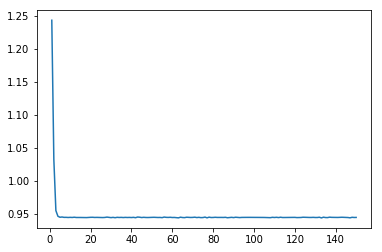

In [18]:
#plot loss
loss = history.history['loss']

epochs = range(1,len(loss)+1)

plt.plot(epochs,loss)

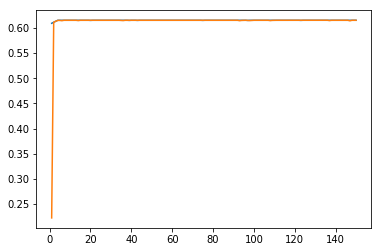

In [19]:
#plot accuracy and f1
acc = history.history['acc']
f1 = history.history['f1']

epochs = range(1,len(loss)+1)

plt.plot(epochs,acc)
plt.plot(epochs,f1)

In [20]:
from sklearn import metrics
#training and dev prediction
y_hat_train = model.predict(X_train)

target_names = ['Normal','AF','Other','Noise']
score = metrics.accuracy_score(y_train, y_hat_train)
print("accuracy:   %0.3f" % score)
#report de metricas
print("classification report:")
print(metrics.classification_report(y_train, y_hat_train,target_names=target_names))


print("confusion matrix:")
print(metrics.confusion_matrix(y_train, y_hat_train))

3824/3824 [==============================] - 1s 154us/step
accuracy:   0.615
classification report:
             precision    recall  f1-score   support

     Normal       0.62      1.00      0.76      2353
         AF       0.00      0.00      0.00       319
      Other       0.00      0.00      0.00      1072
      Noise       0.00      0.00      0.00        80

avg / total       0.38      0.62      0.47      3824

confusion matrix:
[[2353    0    0    0]
 [ 319    0    0    0]
 [1072    0    0    0]
 [  80    0    0    0]]


In [21]:
from sklearn import metrics
#training and dev prediction
y_hat_dev = model.predict(X_dev)

target_names = ['Normal','AF','Other','Noise']



score = metrics.accuracy_score(y_dev, y_hat_dev)
print("accuracy:   %0.3f" % score)
#report de metricas
print("classification report:")
print(metrics.classification_report(y_dev, y_hat_dev,target_names=target_names))


print("confusion matrix:")
print(metrics.confusion_matrix(y_dev, y_hat_dev))

957/957 [==============================] - 0s 190us/step
accuracy:   0.615
classification report:
             precision    recall  f1-score   support

     Normal       0.62      1.00      0.76       589
         AF       0.00      0.00      0.00        80
      Other       0.00      0.00      0.00       268
      Noise       0.00      0.00      0.00        20

avg / total       0.38      0.62      0.47       957

confusion matrix:
[[589   0   0   0]
 [ 80   0   0   0]
 [268   0   0   0]
 [ 20   0   0   0]]
